# Grid operations

In [1]:
# código malla triangular
import numpy as np
import openmesh as om
import matplotlib.pyplot as plt
import math

In [2]:
# mesh = om.read_trimesh('dm.off')
# mesh = om.read_trimesh('halfcircle.off')
# mesh = om.read_trimesh('liberation.off')
# mesh = om.read_trimesh('siete_nodos.off')
mesh = om.read_trimesh('T4.off')
# mesh = om.read_trimesh('refined_mesh.off')

V=mesh.points()
Vx=V[:,0]
Vy=V[:,1]


# Geometry: Data structure



In [3]:
#################################################################
#CALCULAR LONGITUD DE LOS LADOS DE LAS CELDAS
Xbar =[]
Ybar = []
A = [] # areas
Nx = [] #arreglos que guardan las normales
Ny = []

nEdges=len(mesh.edges())
Xe = np.zeros(nEdges) #arreglos que guardan los centros de cada lado
Ye = np.zeros(nEdges)
sigma = np.zeros(nEdges) # longitud de los lados
link_edge_to_cell = np.zeros((nEdges,2))-1

#############################################################################
for fh in mesh.faces():   
    nCell = fh.idx()

    Xf = [] # guardar las coordenadas X de los vertices
    Yf = [] # guardar las coordenadas Y de los vertices
    for vh in mesh.fv(fh):
        P = mesh.point(vh)
        Xf.append(P[0])
        Yf.append(P[1])

    # Calcular el baricentro de la celda
    Xbar.append(sum(Xf)/3)
    Ybar.append(sum(Yf)/3)

    # AREA DE LAS CELDAS    
    A.append(0.5 * np.absolute(Xf[0] * (Yf[2] - Yf[1]) + Xf[1] * (Yf[0] - Yf[2]) + Xf[2] * (Yf[1] - Yf[0])))    
    
    i = 0 # auxilliary counter
    #############################################################################
    for eh in mesh.fe(fh):
        nEdge = eh.idx()
        
        # calculado el punto medio de cada lado
        # lo guardamos en el arreglo
        Xe[nEdge] = 0.5 * (Xf[i-1] + Xf[i]) # Xe = nCentLadoX = aCenint_x
        Ye[nEdge] = 0.5 * (Yf[i-1] + Yf[i]) # nCentLadoY
        
        #############################################################################
        # CALCULAR LA DISTANCIA        
        distX = Xf[i-1] - Xf[i]
        distY = Yf[i-1] - Yf[i]
        
        i=i+1 # iteration index
        
        #formula de la distancia (Longitud segmento); guardamos en el arreglo
        sigma[nEdge] = np.sqrt(pow(distX,2) + pow(distY,2))
        
        # normal unitaria
        Nx.append(-distY / sigma[nEdge])
        Ny.append(+distX / sigma[nEdge])
        
        # link edge to cell
        if link_edge_to_cell[nEdge,0]==-1:
            link_edge_to_cell[nEdge,0]=nCell
        elif link_edge_to_cell[nEdge,1]==-1:
            link_edge_to_cell[nEdge,1]=nCell
        else:
            print('edge overcrowd:', nEdge)
            

# Calculate the geometry of numerical Hamiltonian

There are several suggestion for the numerical Hamiltonian
\begin{align*}
    \hat{H}(G_1, G_2, G_3).
\end{align*}
where $G_i, \ i=1,2,3$ represent the gradient in the triangles $T_1, T_2, T_3$.
The first choice is
\begin{align*}
    H = \Biggl( \frac{\sum_{i=1}^3 \theta_i G_i}{2 \pi} \Biggr) - \frac{C_L}{\pi} \sum_{i=1}^3 \mu_i \Biggl( \frac{G_{i} + G_{i+1}}{2} \Biggr) n_{i+1/2},
\end{align*}
where $\theta_i$ is the angle at the node where triangle $T_i$ is attached, $C_L$ is a Lipschitz constant of the Hamiltonian, $\lambda_i$ is a weighting defined as
\begin{align*}
        \lambda_i  = \tan (\theta_i / 2) + \tan (\theta_{i+1} / 2)
\end{align*}
and $n_{i+1/2}$ is a common edge vector of triangles $T_i, T_{i+1}$.

We can set $C_L = 0$ as the equation of the boundary value problem is stationary, and the second term accounts for the numerical diffusion, beeing $C_L$ a CLF constant. The first term of the numerical Hamiltonian can be interpreted as an evaluation of the Hamiltonion of the averaged gradient.

As a preparatory step to calculate the numerical Hamiltonian
we need to calculate the geometry. A principal design choice is whether the mesh is primary or dual. In our case, the mesh is dual as we attach the solution variables to the baricenters.

For each cell we need to obtain tree angles, between the connections to the neigboring cell centers. In the case of absence of a neigoring cell center, as the border is a boundary the non-existing neigboring cell center is replaced by the edge border.

An alternative choice for the numerical Hamiltonian is
\begin{align*}
    H = \frac{\sum_{i=1}^3 \mu_i H(G_i) - \frac{C_F}{1} \frac{1}{\cos \theta_i / 2} \mu_i U_i n_i ,
\end{align*}
where
\begin{align*}
    \mu_i = \frac{\sin \theta_i}{\sum_{i=1}^3 \sin \theta_i}
\end{align*}
gives the weights for the different sides
and $n_i$ is the centerline vector of $T_i$


\begin{align*}
\end{align*}





In [4]:
nFaces=len(mesh.faces())

link_cell_to_edge = np.zeros((nFaces,3)) # relacion celda a sus bordes
link_cell_to_cell = np.zeros((nFaces,3)) # relacion celda a celda vecinas
link_cell_to_vertex = np.zeros((nFaces,3)) # relacion celda vertices

#obtenemos los maximos y los minimos de los centros de los bordes
nMax_Cx = np.amax(Xe)
nMax_Cy = np.amax(Ye)
nMin_Cx = np.amin(Xe)
nMin_Cy = np.amin(Ye)

Dist_Cell_Edge=[] # Dist_cell_edge : distancia centro celda a centro lado
    
#### INFO CONECTIVIDAD ######################################################
#############################################################################

# recorro las celdas 
for fh in mesh.faces():
    nCell = fh.idx()
    
    #############################################################################
    # 1 & 2
    index = 0
    auxidx = 0 # recorre el auxiliar
        
    for eh in mesh.fe(fh):
        nEdge = eh.idx()

            # 
        auxCell = []
        for ffh in mesh.ff(fh):
            auxCell.append(ffh.idx())
        
        # OBTENEMOS EL VECTOR DE LINK DE LA CELDA CON SUS VECINOS
        
        if mesh.is_boundary(eh):
        # if Xe[nEdge] == nMax_Cx or Xe[nEdge] == nMin_Cx or Ye[nEdge] == nMax_Cy or Ye[nEdge] == nMin_Cy: 
            #evaluo la condicion de frontera
            link_cell_to_cell[nCell, index] = int(-1)            
        else:
            link_cell_to_cell[nCell, index] = auxCell[auxidx]
            auxidx = auxidx+1
            
        Dist_Cell_Edge.append(np.sqrt(pow(Xbar[nCell] - Xe[nEdge], 2) + pow(Ybar[nCell] - Ye[nEdge], 2))) # Dist_cell_edge
        link_cell_to_edge[nCell, index] = nEdge
        index = index + 1
    
    #############################################################################
    # 3.
    # OBTENEMOS LA MATRIZ DE LINK DE LA CELDA CON SUS VERTICES
    index = 0
    for vh in mesh.fv(fh):
        link_cell_to_vertex[nCell,index] = vh.idx()
        index = index + 1
        
dist_to_X = np.zeros((nFaces,3))
for fh in mesh.faces():
    nCell = fh.idx()
    
    i=0
    for eh in mesh.fe(fh):
        nEdge = eh.idx()
        nCell_v = int(link_cell_to_cell[nCell, i]) 
                
        if nCell_v == -1:
            distx = Xbar[nCell] - Xe[nEdge]
            disty = Ybar[nCell] - Ye[nEdge]
            dist_to_X[nCell,i] = np.sqrt(pow(distx,2) + pow(disty,2))
        else:
            distx = Xbar[nCell] - Xbar[nCell_v]
            disty = Ybar[nCell] - Ybar[nCell_v]
            dist_to_X[nCell,i] = np.sqrt(pow(distx,2) + pow(disty,2))
        i=i+1
    
#######################################################################################
#######################################################################################
#CALCULOS DE LA ECUACION

With the links from cell to cell and cell to edge we have access to the local grid that allows to calculate the angles.



The algorithm consists in the calculation of the local grid as the connection of the baricenter of the considered cell to the neighboring baricenters respective edge centers.



In [5]:
link_cell_to_cell

array([[-1., 32.,  5.],
       [74., 35., -1.],
       [77., 18., -1.],
       [-1., 17., 13.],
       [-1., 60., 47.],
       [ 0.,  9., -1.],
       [71.,  7., 34.],
       [11.,  8.,  6.],
       [-1.,  9.,  7.],
       [33.,  8.,  5.],
       [16., 31., -1.],
       [43., -1.,  7.],
       [20., 46., 23.],
       [ 3., 28., 16.],
       [37., 15., 27.],
       [29., 16., 14.],
       [13., 15., 10.],
       [18., 26.,  3.],
       [ 2., 19., 17.],
       [78., 20., 18.],
       [25., 19., 12.],
       [45., 49., 24.],
       [52., 57., -1.],
       [12., 24., 63.],
       [21., 61., 23.],
       [64., 26., 20.],
       [17., 25., 28.],
       [14., 28., 67.],
       [26., 27., 13.],
       [30., 31., 15.],
       [34., 29., 36.],
       [10., 29., 32.],
       [31., 33.,  0.],
       [32., 34.,  9.],
       [ 6., 33., 30.],
       [ 1., 44., 42.],
       [30., 37., 70.],
       [39., 36., 14.],
       [69., 39., 53.],
       [65., 38., 37.],
       [-1., 42., 55.],
       [54., 42.

In [6]:
P

array([3.5       , 0.30000001, 0.        ])

In [7]:
angles = np.zeros((nFaces,3))
mu = np.zeros((nFaces,3))

n_common_edge_vector_x = np.zeros((nFaces,3))
n_common_edge_vector_y = np.zeros((nFaces,3))
n_centerline_vector_x = np.zeros((nFaces,3))
n_centerline_vector_y = np.zeros((nFaces,3))

# Sbar = np.zeros(nFaces)
# Tbar = np.zeros(nFaces)
# T3 = np.zeros((nFaces,3)) # values in the neighbor nodes
# S3 = np.zeros((nFaces,3))
# X3 = np.zeros((nFaces,3))
# Y3 = np.zeros((nFaces,3))


Gx = np.zeros((nFaces,3))
Gy = np.zeros((nFaces,3))
m=np.zeros((3, 3))
b=np.zeros((3, 1))

def get_T_init(x,y):
    return x*(1+0.5*(1-y)**2)

for fh in mesh.faces(): # recorre las caras
        nCell = fh.idx()

        P=[]
        # P.append([Xbar[nCell], Ybar[nCell]])        
        p0 = [Xbar[nCell], Ybar[nCell]]
        
        for i in range(3):
            nEdge = int(link_cell_to_edge[nCell, i])
            nCell_v = int(link_cell_to_cell[nCell, i])
            
            if nCell_v == -1:
                p = [Xe[nEdge], Ye[nEdge]]
            else:
                p = [Xbar[nCell_v], Ybar[nCell_v]]        
            P.append(p)
            # print(P,'\n')
            
        P=np.array(P)
            
        for i in range(3): 
            m[0,0] = p0[0]
            m[0,1] = p0[1]
            m[0,2] = 1
            b[0] = get_T_init(p0[0],p0[1])
            
            m[1,0] = P[i-1, 0]
            m[1,1] = P[i-1, 1]
            m[1,2] = 1
            b[1] = get_T_init(P[i-1, 0], P[i-1, 0])

            m[2,0] = P[(i+1) % 3, 0]
            m[2,1] = P[(i+1) % 3, 1]
            m[2,2] = 1
            b[2] = get_T_init(P[(i+1) % 3, 0], P[(i+1) % 3, 0])
            
            g = np.linalg.solve(m, b)
            
            Gx[nCell, i] = float(g[0])
            Gy[nCell, i] = float(g[1])    
            # one gradient for each i [!]
            
        # print(nCell)
        for i in range(3):
            v1 = np.array(p0)-np.array(P[i])
            v2 = np.array(p0)-np.array(P[i-1])    
            angle = np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2)))
            angles[nCell, i] = angle
            n_common_edge_vector_x[nCell,i] = v1[0]/np.linalg.norm(v1) # common_edge_vector
            n_common_edge_vector_y[nCell,i] = v1[1]/np.linalg.norm(v1)            

            nVertex=link_cell_to_vertex[nCell,i]
            vv = [Xbar[nCell], Ybar[nCell]] - V[int(nVertex),0:2]
            vv = vv/np.linalg.norm(vv)
            n_centerline_vector_x[nCell,i] = vv[0]
            n_centerline_vector_y[nCell,i] = vv[1]            
            
        # calculate other (non-requiered geometry anyway)
        # the reference to angles[nCell,-i] requires all angles calculated
        for i in range(3):
            mu[nCell,i] = math.tan(angles[nCell,i]/2) + math.tan(angles[nCell,i-1]/2)            
            
        # return P
        # B=np.array([1, 1, 1])
        # print(angles.dot(B))

In [8]:
Gx

array([[ 9.30555556e-01,  2.55388889e+00, -6.92777776e-01],
       [ 1.40722211e+00,  4.53889001e-01,  9.30555556e-01],
       [-7.22061111e+01,  9.80672222e+01,  1.29305556e+01],
       [ 5.93055556e+00, -9.78611112e+00,  2.16472222e+01],
       [ 1.29305556e+01,  1.12767203e+02, -8.69060915e+01],
       [ 1.40500000e+00,  1.40500000e+00,  9.98611112e-01],
       [ 1.13777777e+00,  3.49444459e-01,  1.13777777e+00],
       [ 9.31111115e-01,  9.31111115e-01,  1.01277777e+00],
       [ 1.19944445e+00,  1.24500000e+00,  1.24499999e+00],
       [ 1.29277777e+00,  7.91111115e-01,  7.91111115e-01],
       [ 6.13388888e+00, -2.27277777e+00,  1.93055556e+00],
       [ 1.12499999e+00,  1.31944445e+00,  1.12500000e+00],
       [ 3.83111111e+01, -3.99972223e+01,  3.83111111e+01],
       [ 1.72277777e+00,  1.72277777e+00,  7.14861112e+00],
       [ 4.07611114e+00,  4.07611114e+00,  1.47277772e+00],
       [ 1.61944449e+00,  2.37777776e+00,  2.37777776e+00],
       [ 2.80694443e+00,  3.19611112e+00

Calculation of the equations for each cell

In [9]:
# G=np.vstack([Gx,Gy])

for fh in mesh.faces():
    nCell = fh.idx()
    Gloc=[]
    Aloc=[]
    for i in range(3):
        g = [Gx[nCell,i],Gy[nCell,i]]        
        angle = angles[nCell, i]
        Gloc.append(g)
        Aloc.append(angle)
    
    Gloc=np.array(Gloc)
    Aloc=np.array(Aloc)
    # print(Gloc, '; ', Aloc, '; ', Aloc.dot(Gloc))
    gcell = Aloc.dot(Gloc)




In [10]:
Gx

array([[ 9.30555556e-01,  2.55388889e+00, -6.92777776e-01],
       [ 1.40722211e+00,  4.53889001e-01,  9.30555556e-01],
       [-7.22061111e+01,  9.80672222e+01,  1.29305556e+01],
       [ 5.93055556e+00, -9.78611112e+00,  2.16472222e+01],
       [ 1.29305556e+01,  1.12767203e+02, -8.69060915e+01],
       [ 1.40500000e+00,  1.40500000e+00,  9.98611112e-01],
       [ 1.13777777e+00,  3.49444459e-01,  1.13777777e+00],
       [ 9.31111115e-01,  9.31111115e-01,  1.01277777e+00],
       [ 1.19944445e+00,  1.24500000e+00,  1.24499999e+00],
       [ 1.29277777e+00,  7.91111115e-01,  7.91111115e-01],
       [ 6.13388888e+00, -2.27277777e+00,  1.93055556e+00],
       [ 1.12499999e+00,  1.31944445e+00,  1.12500000e+00],
       [ 3.83111111e+01, -3.99972223e+01,  3.83111111e+01],
       [ 1.72277777e+00,  1.72277777e+00,  7.14861112e+00],
       [ 4.07611114e+00,  4.07611114e+00,  1.47277772e+00],
       [ 1.61944449e+00,  2.37777776e+00,  2.37777776e+00],
       [ 2.80694443e+00,  3.19611112e+00

In [11]:
def Hamiltonian(G):
    return 0
    

In [12]:
# not used ...
# G=np.vstack([Gx,Gy])
# NG=(Gx**2+Gy**2)**0.5
# GS=G/NG
#
# print(Gx,' \n ',Gy,' \n ',G,' \n ',NG,' \n ... \n',GS)

In [13]:
    nCell = fh.idx()
    Gloc=[]
    Aloc=[]
    for i in range(3):
        g = [Gx[nCell,i],Gy[nCell,i]]        
        angle = angles[nCell, i]
        Gloc.append(g)
        Aloc.append(angle)

In [14]:
Aloc

[1.0808390027325139, 2.6011731318440066, 2.601173172603066]

In [15]:
########## no necesario dado que se podrán utilizar rutinas predefinidas
# * mesh.is_boundary(eh):

point_is_front = []
# for p in mesh.points():   
for vh in mesh.vertices():
#    #IMPRIMIR LAS COORDENADAS DE CADA VERTICE
    p = mesh.point(vh)
    # if p[0] == nMax_Cx or p[0] == nMin_Cx or p[1] == nMax_Cy or p[1] == nMin_Cy:
    if mesh.is_boundary(vh):
            #evaluo la condicion de frontera
            point_is_front.append(1)
    else:
            point_is_front.append(0)
    
edge_is_front = [] # indica si una interface corresponde a una frontera o no
for eh in mesh.edges():
    nEdge = eh.idx()
    # if Xe[nEdge] == nMax_Cx or Xe[nEdge] == nMin_Cx or Ye[nEdge] == nMax_Cy or Ye[nEdge] == nMin_Cy:
    if mesh.is_boundary(eh):        
        edge_is_front.append(1)
    else:
        edge_is_front.append(0)   

In [16]:
import math

# coeficiente de difusion con múltiples dependencias,
# depende 
def k(t,x,y,c):
    return k0()
    # return k1(t)

def k0():
    return 1

def k1(t):
    e=math.exp(1)
    return e**(2*t)



# Define coefficients
The coefficients ideally depend on various components, k=k(t,x,y,c)

In [17]:
Ce = np.zeros(nEdges)

def get_coefficients_0():
    for eh in mesh.edges():
        nEdge=eh.idx()
        Ce[nEdge] = 1
    return
        
def get_coefficients_1():
    for eh in mesh.edges():
        nEdge=eh.idx()
        
        # dependence on solution variable
        if not(mesh.is_boundary(eh)):
            nCell_0 = link_edge_to_cell[nEdge,0]
            nCell_1 = link_edge_to_cell[nEdge,1]
            
            # Xe[nEdge]
            # Ye[nEdge]
        
            # Xbar[nCell_1]
            # Ybar[nCell_1]            
        else:
            Ce[nEdge] = 0
            
        # dependence on position    
        r = math.sqrt(Xe[nEdge]**2+Ye[nEdge]**2)
        if r < 3:
            Ce[nEdge] = 1
        elif r < 5:
            Ce[nEdge] = 2
        else:
            Ce[nEdge] = 3
        
        # print(eh.idx(), ': \t ', Xe[nEdge], Ye[eh.idx()],'--% .2f' % r, '-', Ce[nEdge] )
        
# get_coefficients_0()
get_coefficients_1()

## Liberación de farmacos
En el modelo de la liberación de farmacos no hay nada particular para el borde.

Solamente tenemos una variable adicional $u_E$
que ocupa un área $A_E$ correspondiente.
Eso lleva a la ecuación discreta
\begin{align*}
    \frac{u_E}{dt} = \frac{u_i - u_E}{d_{Ei}} \frac{ \sigma_{Ei}}{| \Omega_{Ei} |}
\end{align*}



In [18]:
#######################################################################################
def fluxes():
    Flux=[]
    for fh in mesh.faces(): # recorre las caras
                    
        sumCellFlux = getCellFlux_0(fh)
        sumCellFlux = getCellFlux_1(fh)
        sumCellFlux = getCellFlux_2(fh)

        Flux.append(sumCellFlux)
    return Flux
                                         
#######################################################################################
def getCellFlux_2(fh):
        nCell = fh.idx()
        cellFlux = []
                                         
        #recorrer los lados
        for i in range(3):
            # obtengo el indice del lado y de la celda vecina
            nEdge = int(link_cell_to_edge[nCell, i])
            nCell_v = int(link_cell_to_cell[nCell, i])        
            
            if nCell_v == -1: # volumen en el borde
                # flux = Diff*((aF - aU[nCell]) / dist_to_X[nCell,i]) / aArea[nCell]
                #
                # liberacion de fármacos                
                # concentracion en el exterior: Uext
                #
                flux = Ce[nEdge]*((Uext - aU[nCell]) / dist_to_X[nCell,i]) / aArea[nCell]
                
            else:
                flux = Ce[nEdge]*((aU[nCell_v] - aU[nCell]) / dist_to_X[nCell,i]) * sigma[nEdge] / aArea[nCell] 
                
            cellFlux.append(flux)

        return sum(cellFlux)
    
# variante de calcular flujos, para covalidar los procedimientos
#
#     dist_Cell_X[nEdge] : requiere definirlo
#     nEdge              : ¿como acceder?                                         
#######################################################################################
def getCellFlux_1(fh):
        nCell = fh.idx()
        cellFlux = []

        i = 0
        for ffh in mesh.ff(fh):
            nCell_v = ffh.idx()
            nEdge = int(link_cell_to_edge[nCell, i]) # parece que no hay alternativa
            i=i+1
            
            flux = Ce[nEdge]*((aU[nCell_v] - aU[nCell]) / dist_Cell_X[nEdge]) * sigma[nEdge] / aArea[nCell] 
            cellFlux.append(flux)
            
        for eh in mesh.fe(fh):
            nEdge = eh.idx()
            if mesh.is_boundary(eh):        
                flux = Ce[nEdge]*((0 - aU[nCell]) / dist_Cell_X[nEdge]) * sigma[nEdge] / aArea[nCell]
                cellFlux.append(flux)

        return sum(cellFlux)


In [19]:
#######################################################################################
# version inicial

def getCellFlux_0(fh):
        #recorrer los lados
        nCell = fh.idx() # obtenemos indice de la celda, 
        cellFlux = [] # Almacenamos los flujos de la cara
      
        for i in range(3):
            # obtengo el indice del lado y de la celda vecina
            nEdge = int(link_cell_to_edge[nCell, i])
            nCell_v = int(link_cell_to_cell[nCell, i])
            
            if nCell_v == -1: # volumen en el borde
                #Calculo la distancia entre el baricentro y el centro del borde de frontera
                distx = Xbar[nCell] - Xe[nEdge]
                disty = Ybar[nCell] - Ye[nEdge]
                l_f = np.sqrt(pow(distx,2) + pow(disty,2))
                
                #Calculo la distancia delta como productro de la dist entre los baricentros por la normal del segmento
                delta_distx = Nx[nCell][i] * distx
                delta_disty = Ny[nCell][i] * disty
                delta_dist = np.sqrt(pow(delta_distx,2) + pow(delta_disty,2))

                # Calculo el flujo
                flux = Ce[nEdge]*((aF - aU[nCell]) / delta_dist) / aArea[nCell] 

            else:
                # Calculo la distancia entre los baricentros
                distx = Xbar[nCell] - Xbar[nCell_v]
                disty = Ybar[nCell] - Ybar[nCell_v]
                l_f = np.sqrt(pow(distx,2) + pow(disty,2))
                
                # Calculo la distancia delta como productro de la dist entre los baricentros por la normal del segmento
                delta_distx = Nx[nCell][i] * distx
                delta_disty = Ny[nCell][i] * disty
                delta_dist = np.sqrt(pow(delta_distx,2) + pow(delta_disty,2))

                # Calculo el flujo
                flux = Ce[nEdge]*((aU[nCell_v] - aU[nCell]) / delta_dist) * sigma[nEdge] / aArea[nCell] 
                
            cellFlux.append(flux)                                         
                                         
        return sum(cellFlux)                       

                                         
def residuos(u):
    # ut: solución actual
    # dt: paso de tiempo
    # u: solución en nuevo paso de tiempo
    return ut + dt*Fluxes(u) - u

### Integración del tiempo
* T: el tiempo físico como parámetro físico
* en número de instancias del tiempo físico
* opción de tener intervalos del tiempo adaptivo
* de todo modo contar con una estructura semi-discreta, donde la discretización del tiempo y del espacio se hacen aparte

In [20]:
#######################################################################################
#######################################################################################


# Concentración inicial
U=np.ones(len(mesh.points()))*2

UU = []
UU.append(U)

sizeT = 20 # tamaño de vector de tiempo
T=10
TT = np.linspace(0,T,sizeT) # arreglo de tiempo


#######################################################################################
#######################################################################################

for k in range(2,len(TT)):
    dt = TT[k] - TT[k-1]
    # U = U + dt * fluxes() # calculo concentracion en la celda
    
    UU.append(U)


#######################################################################################
#######################################################################################



## Plot the mesh

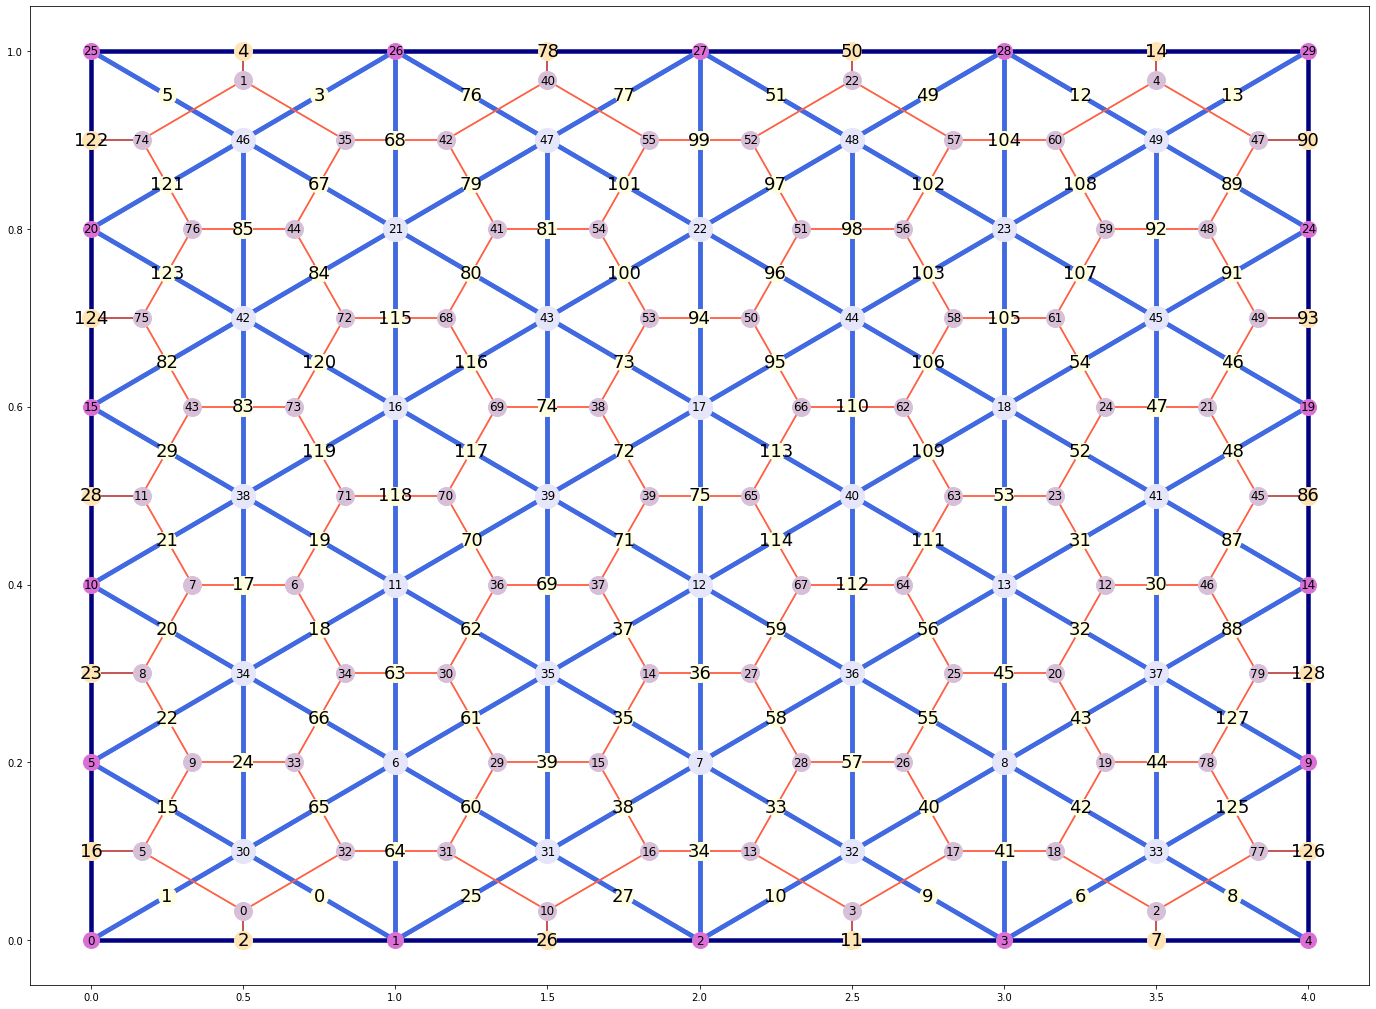

In [21]:
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(24,18))
#############################################################################
for fh in mesh.faces():
    nCell = fh.idx()
    
    Xf = [] # guardar las coordenadas X de los vertices
    Yf = [] # guardar las coordenadas Y de los vertices
    for vh in mesh.fv(fh):
        P = mesh.point(vh)
        Xf.append(P[0])
        Yf.append(P[1])
        
    i=0
    #############################################################################
    for eh in mesh.fe(fh):
        nEdge = eh.idx()    

        aX=[Xf[i-1], Xf[i]]
        aY=[Yf[i-1], Yf[i]]
        
        if mesh.is_boundary(eh):
            color = 'navy'
        else:
            color = 'royalblue'
            
        plt.plot(aX, aY, marker = 'o', color = color, linewidth=4.5)
        i=i+1
        

        
for fh in mesh.faces():
    nCell = fh.idx() # devuelve el indice de la celda
        
    # print('\n')
    for ffh in mesh.ff(fh):
        nCell2 = ffh.idx()
        aX=[Xbar[nCell], Xbar[nCell2]]
        aY=[Ybar[nCell], Ybar[nCell2]]
                            
        plt.plot(aX, aY, marker = 'o', color = 'tomato', linewidth=1.5)    


    
for fh in mesh.faces():
    nCell = fh.idx()
    
    for eh in mesh.fe(fh):
        nEdge = eh.idx()    

        if mesh.is_boundary(eh):
        # if True:
            aX=[Xbar[nCell], Xe[nEdge]]
            aY=[Ybar[nCell], Ye[nEdge]]
                            
            plt.plot(aX, aY, marker = 'o', color = 'firebrick', linewidth=1.5)
    
        
for fh in mesh.faces():   
    nCell = fh.idx()
    plt.plot(Xbar[nCell], Ybar[nCell], marker = 'o', color ='thistle', markersize=18)
    plt.text(Xbar[nCell], Ybar[nCell], nCell, fontsize=12, horizontalalignment='center', verticalalignment='center') # , color = 'g')    
    # plt.show()    
    

for eh in mesh.edges():
    nEdge = eh.idx()
    # if edge_is_front[nEdge]==1:
    if mesh.is_boundary(eh):
        color = 'moccasin'
    else:
        color = 'lightyellow'
        
    plt.plot(Xe[nEdge], Ye[nEdge], marker = 'o', color = color, markersize=18)
    plt.text(Xe[nEdge], Ye[nEdge], nEdge, fontsize=18, horizontalalignment='center', verticalalignment='center')
    
    # print(eh.idx(), mesh.is_boundary(eh), edge_is_front[nEdge])    
    
    
#############################################################################

for vh in mesh.vertices():
    p = mesh.point(vh)
    
    # print(eh.idx(), mesh.is_boundary(vh), point_is_front[vh.idx()]) 

    # if point_is_front[vh.idx()]==1:
    if mesh.is_boundary(vh):    
            color = 'orchid'
            markersize=16
    else:
            color = 'lavender'
            markersize=24
            
    plt.plot(p[0], p[1], 'o', markersize=markersize, color=color)
    plt.text(p[0], p[1], vh.idx(), fontsize=12, horizontalalignment='center', verticalalignment='center')
    


    #
    # List of named colors
    #
    # https://matplotlib.org/3.1.0/gallery/color/named_colors.html 
    
        

